In [ ]:
%pip install pystac_client

In [3]:
from os.path import join

import pystac_client
from shapely.geometry import mapping

from rastervision.pipeline.file_system.utils import json_to_file, file_to_json
from rastervision.core.box import Box
from rastervision.core.data import (
    RasterioSourceConfig, SceneConfig, ChipClassificationGeoJSONStoreConfig,
    XarraySourceConfig, STACItemConfig, StatsTransformerConfig)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Set output directory:

In [4]:
out_dir = 's3://raster-vision-ahassan/rvtest/eurosat_sagemaker/20231107/'

# Pick a trained model

Specify a URI for a Raster Vision model-bundle. For this example, we use a chip classification model trained on the [EuroSAT dataset](https://github.com/phelber/EuroSAT).

In [6]:
model_bundle_uri = 's3://azavea-research-public-data/raster-vision/examples/tutorials-data/eurosat/bundle/model-bundle.zip'

# Get a Sentinel-2 scene from a STAC API

Define an AOI:

In [5]:
# Paris, France
bbox = Box(ymin=48.8155755, xmin=2.224122, ymax=48.902156, xmax=2.4697602)

Query a STAC API:

In [8]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')

bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
items = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-l2a'],
    datetime='2023-06-01/2023-06-05',
).get_all_items()
len(items)

1

Pick a specific STAC item and serialize it to a file on S3:

In [6]:
item = items[0]
item_uri = join(out_dir, 'stac-item.json')
json_to_file(item.to_dict(), item_uri)

# Configure Raster Vision

Define a Raster Vision [`SceneConfig`](https://docs.rastervision.io/en/stable/api_reference/_generated/rastervision.core.data.scene_config.SceneConfig.html#sceneconfig), which specifies how the raster is to be read and how the predictions are to be written:

In [7]:
raster_source_config = XarraySourceConfig(
    stac=STACItemConfig(
        uri=item_uri, 
        assets=['red', 'green', 'blue']),
    bbox_map_coords=tuple(bbox),
    transformers=[StatsTransformerConfig(stats_uri=join(out_dir, 'stats.json'))]
)

pred_uri = join(out_dir, 'preds.json')
label_store_config = ChipClassificationGeoJSONStoreConfig(uri=pred_uri)

scene_config = SceneConfig(
    id='test_scene',
    raster_source=raster_source_config,
    label_store=label_store_config,
)

Serialize the `SceneConfig` save it to a file on S3:

In [9]:
scene_config_uri = join(out_dir, 'scene-config.json')
json_to_file(scene_config.dict(), scene_config_uri)

Inspect S3 directory:

In [10]:
! aws s3 ls {out_dir}

2023-11-07 21:29:39        757 scene-config.json
2023-11-07 21:29:38      23021 stac-item.json
2023-11-07 20:41:13        192 stats.json


# Run prediction on AWS SageMaker

**Note:** To be able to run this section, you will need an AWS account and an IAM role with the appropriate SageMaker permissions.

In [ ]:
from rastervision.aws_sagemaker import AWSSageMakerRunner

Define CLI command to run the prediction:

In [11]:
cmd = ['rastervision', 'predict_scene', model_bundle_uri, scene_config_uri]
print(' '.join(cmd))

rastervision predict_scene s3://raster-vision-ahassan/eurosat/20231107/bundle/model-bundle.zip s3://raster-vision-ahassan/rvtest/eurosat_sagemaker/20231107/scene-config.json


Run the command on AWS SageMaker:

In [12]:
runner = AWSSageMakerRunner()
runner.run_command(
    cmd=cmd,
    role='AmazonSageMakerExecutionRole',
    image_uri='279682201306.dkr.ecr.us-east-1.amazonaws.com/raster-vision-ahassan',
    instance_type='ml.p3.2xlarge',
    job_name='stac-pred',
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:botocore.tokens:Loading cached SSO token for rv
INFO:sagemaker:Creating processing-job with name stac-pred-2023-11-07-21-29-39-437


................................................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
2023-11-07 21:37:55:rastervision.pipeline.file_system.utils: INFO - Downloading s3://raster-vision-ahassan/eurosat/20231107/bundle/model-bundle.zip to /opt/data/tmp/cache/s3/raster-vision-ahassan/eurosat/20231107/bundle/model-bundle.zip...
2023-11-07 21:37:55:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle /opt/data/tmp/tmpw3939e8d/bundle/model-bundle.zip.
2023-11-07 21:37:55:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpw3939e8d/model-bundle
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
#015  0%|          | 0.00/44.7M [00:00<?, ?B/s]#015 39%|███▉      | 17.4M/44.7M [00:00<00:00, 182MB/s]#015 8

Inspect the S3 directory again. Note the new `preds.json` file containing predictions.

In [13]:
! aws s3 ls {out_dir}

2023-11-07 21:38:16     230689 preds.json
2023-11-07 21:29:39        757 scene-config.json
2023-11-07 21:29:38      23021 stac-item.json
2023-11-07 20:41:13        192 stats.json


---

# Visualize predictions

## Using Folium

In [ ]:
%pip install folium 

In [14]:
import folium
import geopandas as gpd

gdf = gpd.read_file(pred_uri)

In [78]:
from rastervision.core.data import ClassConfig

CLASS_NAMES = [
    'AnnualCrop',
    'HerbaceousVeg.',
    'Industrial',
    'PermanentCrop',
    'River',
    'Forest',
    'Highway',
    'Pasture',
    'Residential',
    'SeaLake',
]
class_config = ClassConfig(names=CLASS_NAMES)

def style_function(feature):
    class_id = feature['properties']['class_id']
    color_tuple = class_config.colors[class_id]
    color = '#' + ''.join(f'{i:02X}' for i in color_tuple)
    tooltip = class_config.names[class_id]
    out = dict(
        fillColor=color,
        color='black',
        weight=2,
        fillOpacity=0.5,
        tooltip=tooltip,
    )
    return out

In [ ]:
loc = np.array(gdf.unary_union.centroid.xy).squeeze().tolist()[::-1]
m = folium.Map(location=loc, zoom_start=12)

legend_html = '<div style="position: fixed; top: 50px; left: 50px; background-color: white; border: 2px solid gray; z-index: 1000; padding: 5px;">'
for key, color_tuple in zip(class_config.names, class_config.colors):
    color = '#' + ''.join(f'{i:02X}' for i in color_tuple)
    legend_html += f'<div style="width: 20px; height: 20px; background-color: {color}; display: inline-block;"></div>'
    legend_html += f'<div style="display: inline-block; margin-left: 5px;">{key}</div><br>'
legend_html += '</div>'

m.get_root().html.add_child(folium.Element(legend_html))
folium.GeoJson(gdf, style_function=style_function).add_to(m)
m

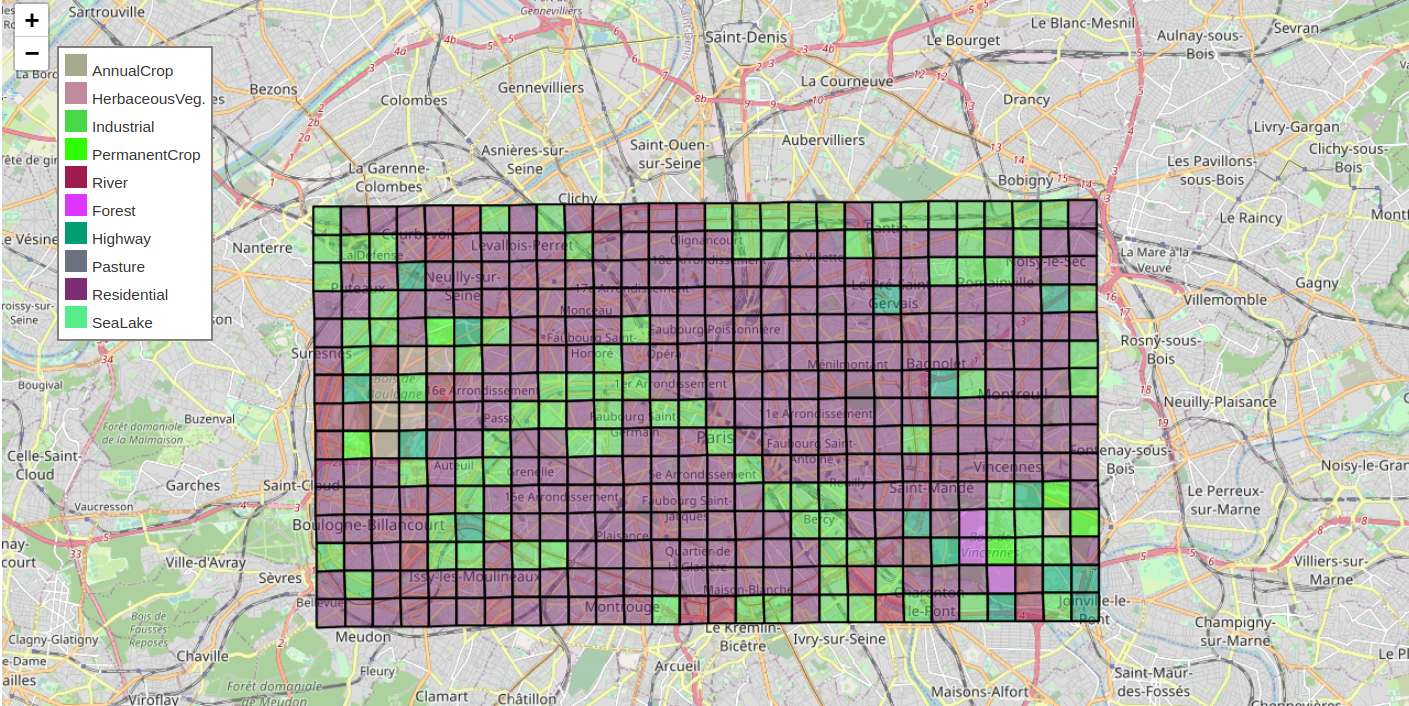

---

## Using Raster Vision

In [27]:
import numpy as np
import torch

from rastervision.core.box import Box
from rastervision.core.data import (
    ChipClassificationGeoJSONStore, ClassConfig, GeoJSONVectorSource)
from rastervision.pytorch_learner import ClassificationVisualizer

CLASS_NAMES = [
    'AnnualCrop',
    'HerbaceousVeg.',
    'Industrial',
    'PermanentCrop',
    'River',
    'Forest',
    'Highway',
    'Pasture',
    'Residential',
    'SeaLake',
]
class_config = ClassConfig(names=CLASS_NAMES)
viz = ClassificationVisualizer(CLASS_NAMES)

In [ ]:
raster_source = raster_source_config.build()
label_store = ChipClassificationGeoJSONStore(
    pred_uri, 
    class_config=class_config,
    crs_transformer=raster_source.crs_transformer,
)
labels = label_store.get_labels()

In [10]:
windows = np.random.choice(labels.get_cells(), 8)
windows_local_coords = [w.to_local_coords(raster_source.bbox) for w in windows]

In [11]:
imgs = [raster_source[w] for w in windows_local_coords]
preds = [labels.get_cell_scores(w) for w in windows]

imgs = torch.from_numpy(np.stack(imgs)).permute(0, 3, 1, 2)
preds = torch.tensor(preds)

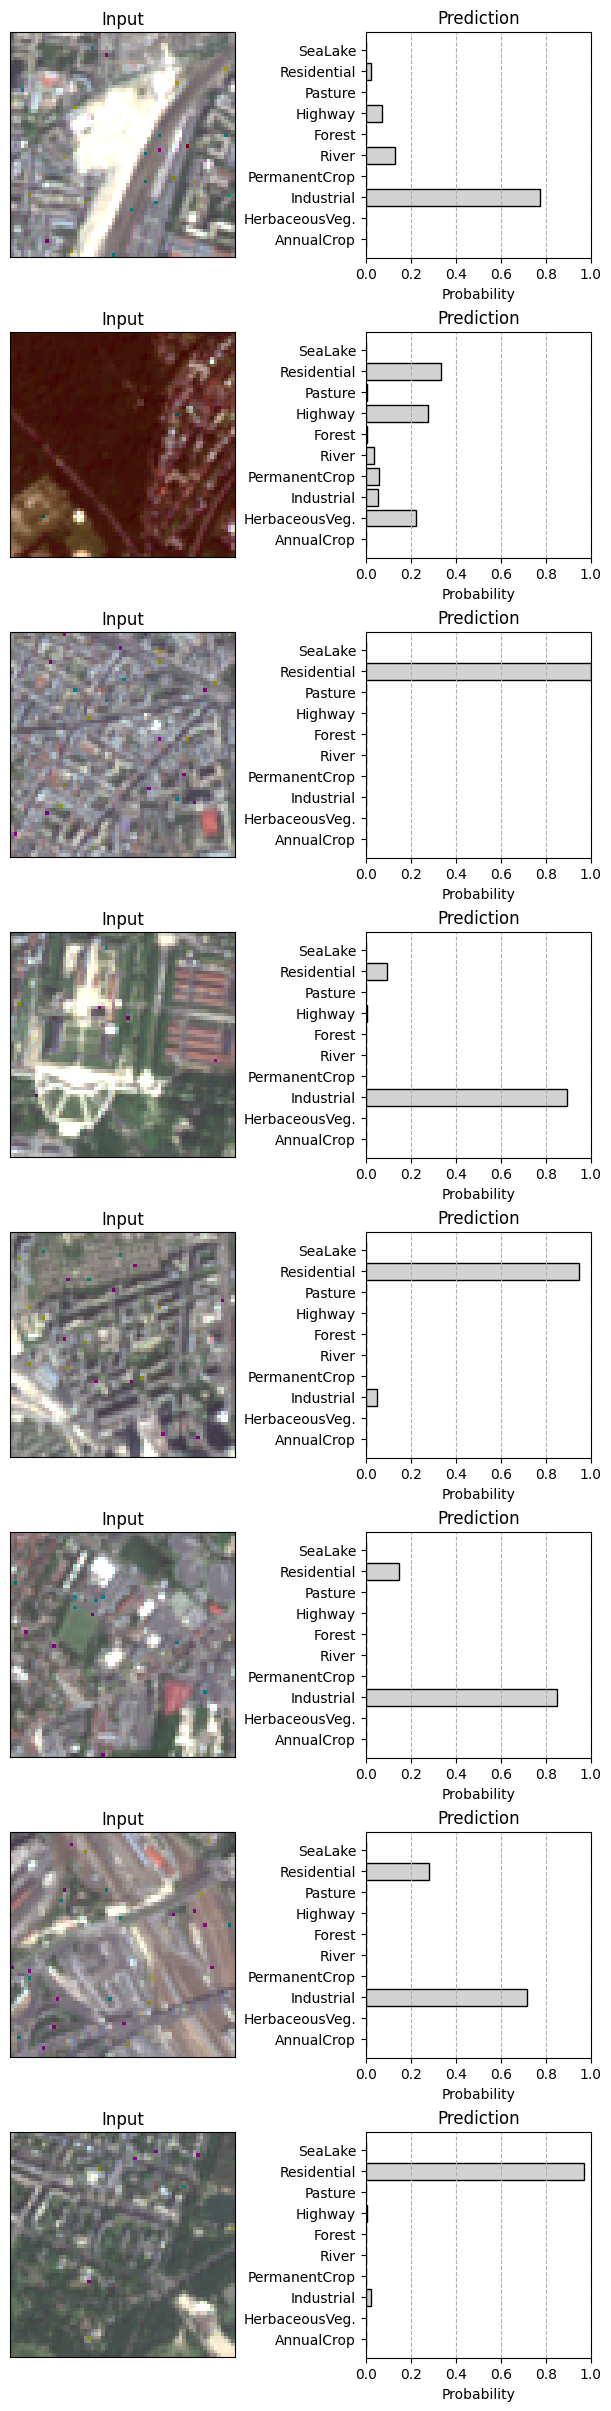

In [62]:
viz.plot_batch(imgs, y=None, z=preds, show=True)